In [9]:
# Build neural network

# read training data
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

#df = pd.Dataframe()
df_train = pd.read_csv('./measuring-customer-happiness/train_hp.csv', encoding='utf-8')
print(df_train.head(3))

#df_test = pd.read_csv('./measuring-customer-happiness/test_hp.csv', encoding='utf-8')
#print(df_test.head(3))

   User_ID                                        Description  \
0  id10326  The room was kind of clean but had a VERY stro...   
1  id10327  I stayed at the Crown Plaza April -- - April -...   
2  id10328  I booked this hotel through Hotwire at the low...   

        Browser_Used Device_Used Is_Response  
0               Edge      Mobile   not happy  
1  Internet Explorer      Mobile   not happy  
2            Mozilla      Tablet   not happy  


In [10]:
df_train = df_train[['Description', 'Is_Response']]
print(df_train.head())

                                         Description Is_Response
0  The room was kind of clean but had a VERY stro...   not happy
1  I stayed at the Crown Plaza April -- - April -...   not happy
2  I booked this hotel through Hotwire at the low...   not happy
3  Stayed here with husband and sons on the way t...       happy
4  My girlfriends and I stayed here to celebrate ...   not happy


In [11]:
# select only rows with happy values and reduce happy values to same amount as not happy values
df_happy = df_train.loc[df_train['Is_Response'] == 'happy']
df_not_happy = df_train.loc[df_train['Is_Response'] == 'not happy']
print(df_happy)

                                             Description Is_Response
3      Stayed here with husband and sons on the way t...       happy
5      We had - rooms. One was very nice and clearly ...       happy
7      My wife & I stayed in this glorious city a whi...       happy
8      My boyfriend and I stayed at the Fairmont on a...       happy
10     Steps off Times Square, nice rooms, stayed - n...       happy
11     Me, the Wife and - kids stayed here on Valenti...       happy
13     I highly recommend the Hawthorne Terrace as an...       happy
14     I found the hotel clean and nicely located. Go...       happy
15     Stayed at the Elan from --th to --th October a...       happy
18     We stayed here for - nights and were really ha...       happy
21     This is everything you could want from a hotel...       happy
23     I really liked this hotel. The staff were wond...       happy
24     My wife and spent - days there this month as a...       happy
26     Took a girls trip to LA and

In [12]:
# only get the first 12411 rows of happy dataframe
df_happy = df_happy.head(12411)
print(df_happy)

                                             Description Is_Response
3      Stayed here with husband and sons on the way t...       happy
5      We had - rooms. One was very nice and clearly ...       happy
7      My wife & I stayed in this glorious city a whi...       happy
8      My boyfriend and I stayed at the Fairmont on a...       happy
10     Steps off Times Square, nice rooms, stayed - n...       happy
11     Me, the Wife and - kids stayed here on Valenti...       happy
13     I highly recommend the Hawthorne Terrace as an...       happy
14     I found the hotel clean and nicely located. Go...       happy
15     Stayed at the Elan from --th to --th October a...       happy
18     We stayed here for - nights and were really ha...       happy
21     This is everything you could want from a hotel...       happy
23     I really liked this hotel. The staff were wond...       happy
24     My wife and spent - days there this month as a...       happy
26     Took a girls trip to LA and

In [13]:
frames = [df_happy, df_not_happy]
df_train = pd.concat(frames)
print(df_train)

                                             Description Is_Response
3      Stayed here with husband and sons on the way t...       happy
5      We had - rooms. One was very nice and clearly ...       happy
7      My wife & I stayed in this glorious city a whi...       happy
8      My boyfriend and I stayed at the Fairmont on a...       happy
10     Steps off Times Square, nice rooms, stayed - n...       happy
11     Me, the Wife and - kids stayed here on Valenti...       happy
13     I highly recommend the Hawthorne Terrace as an...       happy
14     I found the hotel clean and nicely located. Go...       happy
15     Stayed at the Elan from --th to --th October a...       happy
18     We stayed here for - nights and were really ha...       happy
21     This is everything you could want from a hotel...       happy
23     I really liked this hotel. The staff were wond...       happy
24     My wife and spent - days there this month as a...       happy
26     Took a girls trip to LA and

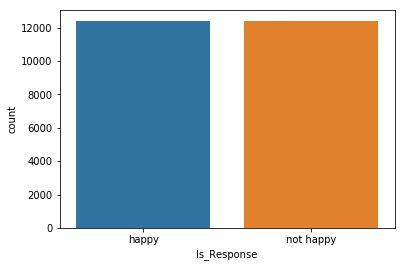

In [14]:
import seaborn as sns

sns.countplot(x='Is_Response', data=df_train)

In [15]:
# Data Preprocessing

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

X = []
sentences = list(df_train['Description'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [16]:
X[3]


'My boyfriend and stayed at the Fairmont on recent trip to San Francisco could not recommend this hotel more called the hotel few weeks before to order cake to be delivered to our room on our first night to celebrate my boyfriend birthday was immediately connected directly to the pastry chef who helped me to design the most delicious cake have ever eaten in my entire life The rooms are large and luxurious with wonderful old world feel Most importantly don miss dinner at the Tonga Room What fun restaurant Definitely order Scorpion Bowl but only if you re staying in the hotel they re strong '

In [17]:
# binary classification for happy and not_happy 

y = df_train['Is_Response']

y = np.array(list(map(lambda x: 1 if x=="happy" else 0, y)))

# 1) Simple Neural Network

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
# Prepare embedding layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [21]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove.twitter.27B/glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [22]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [23]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3451700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 3,461,701
Trainable params: 10,001
Non-trainable params: 3,451,700
_________________________________________________________________
None


# Model training

In [25]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 15885 samples, validate on 3972 samples
Epoch 1/6
15885/15885 [==============================] - 1s 35us/step - loss: 0.5572 - acc: 0.7130 - val_loss: 0.5006 - val_acc: 0.7578
Epoch 2/6
15885/15885 [==============================] - 0s 17us/step - loss: 0.4247 - acc: 0.8089 - val_loss: 0.4930 - val_acc: 0.7596
Epoch 3/6
15885/15885 [==============================] - 0s 17us/step - loss: 0.3748 - acc: 0.8393 - val_loss: 0.4993 - val_acc: 0.7581
Epoch 4/6
15885/15885 [==============================] - 0s 16us/step - loss: 0.3440 - acc: 0.8592 - val_loss: 0.5033 - val_acc: 0.7644
Epoch 5/6
15885/15885 [==============================] - 0s 17us/step - loss: 0.3229 - acc: 0.8674 - val_loss: 0.5156 - val_acc: 0.7573
Epoch 6/6
15885/15885 [==============================] - 0s 17us/step - loss: 0.3066 - acc: 0.8761 - val_loss: 0.5265 - val_acc: 0.7545


# Evaluation of model 

In [26]:
score = model.evaluate(X_test, y_test, verbose=1)

4965/4965 [==============================] - 0s 12us/step


In [27]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5313199824316864
Test Accuracy: 0.7522658610271903


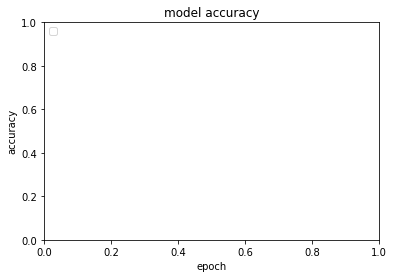

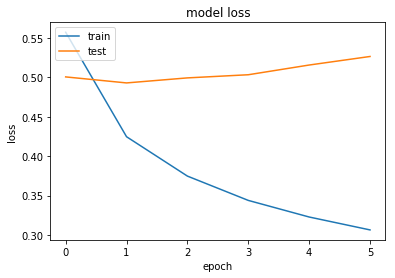

In [28]:
import matplotlib.pyplot as plt

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# 2) Convolutional Neural Network

In [29]:
from keras.layers.convolutional import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [30]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          3451700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,515,957
Trainable params: 64,257
Non-trainable params: 3,451,700
_________________________________________________________________
None


# Model Training & Evaluation 

In [31]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 15885 samples, validate on 3972 samples
Epoch 1/6
15885/15885 [==============================] - 6s 376us/step - loss: 0.4966 - acc: 0.7564 - val_loss: 0.4378 - val_acc: 0.7981
Epoch 2/6
15885/15885 [==============================] - 5s 329us/step - loss: 0.3761 - acc: 0.8385 - val_loss: 0.3919 - val_acc: 0.8258
Epoch 3/6
15885/15885 [==============================] - 5s 309us/step - loss: 0.3231 - acc: 0.8688 - val_loss: 0.3819 - val_acc: 0.8293
Epoch 4/6
15885/15885 [==============================] - 5s 303us/step - loss: 0.2801 - acc: 0.8938 - val_loss: 0.3704 - val_acc: 0.8406
Epoch 5/6
15885/15885 [==============================] - 5s 306us/step - loss: 0.2420 - acc: 0.9121 - val_loss: 0.3734 - val_acc: 0.8379
Epoch 6/6
4965/4965 [==============================] - 1s 167us/step


In [32]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3667120654357284
Test Accuracy: 0.8330312185417129


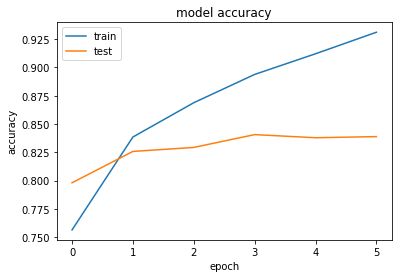

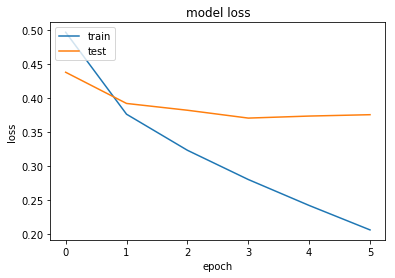

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# 3) Recurrent Neural Network: LSTM (Long Short Term Memory network)

In [34]:
from keras.layers.recurrent import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [35]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          3451700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,569,077
Trainable params: 117,377
Non-trainable params: 3,451,700
_________________________________________________________________
None


# Model Training & Evaluation 

In [36]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)


Train on 15885 samples, validate on 3972 samples
Epoch 1/6
15885/15885 [==============================] - 26s 2ms/step - loss: 0.5591 - acc: 0.7184 - val_loss: 0.5351 - val_acc: 0.7518
Epoch 2/6
15885/15885 [==============================] - 23s 1ms/step - loss: 0.4682 - acc: 0.7902 - val_loss: 0.4385 - val_acc: 0.8039
Epoch 3/6
15885/15885 [==============================] - 23s 1ms/step - loss: 0.4344 - acc: 0.8077 - val_loss: 0.4261 - val_acc: 0.8097
Epoch 4/6
15885/15885 [==============================] - 23s 1ms/step - loss: 0.4062 - acc: 0.8218 - val_loss: 0.4017 - val_acc: 0.8250
Epoch 5/6
15885/15885 [==============================] - 23s 1ms/step - loss: 0.3807 - acc: 0.8344 - val_loss: 0.3836 - val_acc: 0.8278
Epoch 6/6
4965/4965 [==============================] - 3s 526us/step


In [37]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.38247709490981585
Test Accuracy: 0.8302114803625378


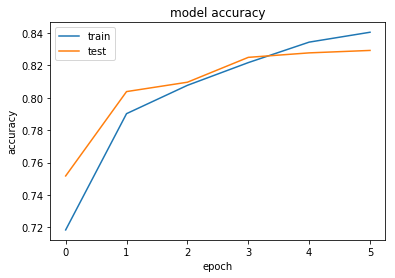

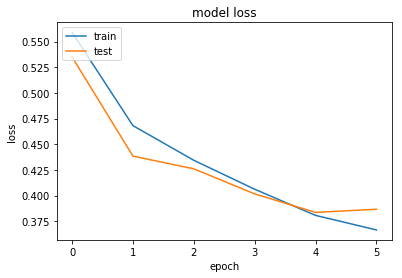

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# Load facebook comments

In [153]:
import json
import requests

# api-endpoint
burghard_api_url = "https://graph.facebook.com/v4.0/me?fields=id%2Cname%2Cposts%7Bcomments%2Clikes%2Creactions%7Bname%2Ctype%2Cid%7D%7D%2Cfeed&access_token=EAAlcIv35CUUBACAL7BAOaT1Fm4mn84wsn0yqOr2UU9R5FG59beXoymQAdA47G4jQqtcW9iZBhCrwlW0VxOQNEUTNgWK4ZBM6vjTA9BthBw7jwM55RKKVgYRt0V4tFcQZAthLHPMZBAZBZBnoHRpD3PXeZBZBilgnaxHJuHoMg7E4dpYdhZAbioeaA33hviyR6DZAj6ZBWh3896phZAo8ft9yV26Y"

lachmann_cruises_api_url = "https://graph.facebook.com/v5.0/me?fields=id%2Cname%2Cposts%7Bcomments%2Csharedposts%7D&access_token=EAAlcIv35CUUBAKDaXZA3zrldcprNX4RosQpbZBAVn5WvMmzp6fwh3Q17zB6qiHMf3OZCiLdx3GSrhGma0fDkYwPGQzj6zYqQw3pdpv5ZBAUoWZAsO2OiCUKHlBvMNOp2lDx2On9q0jWZC7pC2XynX6OigHn9TswWQfpfaxGS2tIRYp1Dm2JYEHTKAlbf5juQIkoXmnKqk1wsIDFUqYebjj" 

new_url =  "https://graph.facebook.com/v5.0/me?fields=id%2Cname%2Clikes%2Cposts&access_token=EAAlcIv35CUUBAEXpcPy1a1OtHIrEw3qD79EZBZCk0oAPBYO8F7tvg5xKvV3XcbevYdgwvjE9vTXVAc4cW014I5FkGlpIQgjAZAi8c0C0cIJSNqYzqJfP78Bq1Cdc6u8mITjpdRZCx73dsrjYyfQsLiKRZCdAShWSpHrFHj7CXbvim8hYSjFbwWreIt2mOUZAmATaXqTHNUhKdXsO9cNHxS"

response = requests.get(new_url)
json_data = json.loads(response.text)
posts = json_data['posts']


for i in posts['data']:
    message = i['message']
    print(message)

Mega Kreuzfahrt
Erster Post von Lachmann 😃
Date and time: Sat Nov 23 16:09:53 2019
error
Date and time: Sat Nov 23 16:10:05 2019
error
Date and time: Sat Nov 23 16:10:16 2019
error
Date and time: Sat Nov 23 16:10:53 2019
error
Date and time: Sat Nov 23 16:10:54 2019
error
Date and time: Sat Nov 23 16:11:07 2019
error
Date and time: Sat Nov 23 16:11:16 2019
error
Date and time: Sat Nov 23 16:11:28 2019
error
Date and time: Sat Nov 23 16:11:36 2019
error
Date and time: Sat Nov 23 16:11:44 2019
Date and time: Sat Nov 23 16:11:44 2019
error
error
Date and time: Sat Nov 23 16:11:53 2019
error
Date and time: Sat Nov 23 16:14:15 2019
error
Date and time: Sat Nov 23 16:16:54 2019
error
Date and time: Sat Nov 23 16:17:00 2019
error
Date and time: Sat Nov 23 16:17:08 2019
error
Date and time: Sat Nov 23 16:17:18 2019
Date and time: Sat Nov 23 18:14:21 2019


Exception in thread Thread-218:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/anaconda3/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "/anaconda3/lib/pyth

Date and time: Sat Nov 23 20:08:28 2019


Exception in thread Thread-219:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/anaconda3/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "/anaconda3/lib/pyth

Date and time: Sun Nov 24 04:15:16 2019


Exception in thread Thread-220:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/anaconda3/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "/anaconda3/lib/pyth

Date and time: Sun Nov 24 11:13:54 2019
error
Date and time: Sun Nov 24 11:14:05 2019
error
Date and time: Sun Nov 24 11:14:11 2019
error
Date and time: Sun Nov 24 11:14:25 2019
error
Date and time: Sun Nov 24 11:14:34 2019
error
Date and time: Sun Nov 24 11:14:41 2019
error
Date and time: Sun Nov 24 11:14:46 2019
error
Date and time: Sun Nov 24 11:14:49 2019
error
Date and time: Sun Nov 24 11:14:55 2019
error
Date and time: Sun Nov 24 11:15:23 2019
error
Date and time: Sun Nov 24 11:15:26 2019
error
Date and time: Sun Nov 24 11:15:41 2019
error


# Load facebook comments

# Predict sentiments

In [39]:
instance = X[57]

print(instance)


We travel for work and m constantly looking for new and intersting places to stay The Inn at The Black Olive was perfect didn feel like was stuck in another hotel but rather staying somewhere fun and relaxing The location was amazing and the beds are really comfortable The restaurant upstairs was excellent Everyone was really nice and helpful only had few thoughts that weren totally positive but they in no way will keep me from staying there every time we re in Baltimore for work The TV in the living room was on the smaller side As don watch TV lot that doesn really matter to me There was no dock or stereo hookup for an ipod Would have been nice but again wasn there to just sit in the room for hours They only carried glass bottles for water get why for sure but it would have been nice to have something more easy to carry outside the hotel Maybe have water bottles in the room that they can charge for 


####  - convert review into numeric form (using the tokenizer)
####  - text_to_sequences method will convert the sentence into its numeric counter part
####  - positive = 1, negative = 0
####  - sigmoid function predicts floating value between 0 and 1. 
####  - value < 0.5 = negative sentiment 
####  - value > 0.5 = positive sentiment 


In [10]:
# load test 

import pandas as pd
#tokenizer = Tokenizer(num_words=5000)


df_test = pd.read_csv('./measuring-customer-happiness/test_hp.csv', encoding='utf-8')
#print(df_test)
df_test = df_test['Description']
df_test.head()
for i in df_test:
    i = tokenizer.texts_to_sequences(i)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]

    instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

    model.predict(instance)

NameError: name 'tokenizer' is not defined

In [11]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

NameError: name 'tokenizer' is not defined

# Send email

In [85]:
import smtplib, ssl

port = 587  # For starttls
smtp_server = "smtp.gmail.com"
sender_email = "burghard.lachmann@gmail.com"
receiver_email = "jackyaudrey2015@gmail.com"
password = 'Brunhilde'
message = """\
Subject: Hi there

This message is sent from Python."""

context = ssl.create_default_context()
with smtplib.SMTP(smtp_server, port) as server:
   # server.ehlo()  # Can be omitted
    server.starttls(context=context)
    #server.ehlo()  # Can be omitted
    server.login(sender_email, password)
    server.sendmail(sender_email, receiver_email, message)

Sat Nov 23 15:19:05 2019
{"id":"111346246934625","name":"Burghard Lachmann","posts":{"data":[{"id":"111346246934625_111339746935275","comments":{"data":[
{"created_time":"2019-09-28T09:29:49+0000","from":{"name":"Burghard Lachmann","id":"111346246934625"},"message":"Super Positiv \
ud83d\ude0d","id":"111339746935275_111343456934904"},{"created_time":"2019-09-28T09:30:09+0000","from":{"name":"Burghard Lachman
n","id":"111346246934625"},"message":"Super Negativ \ud83e\udd2c","id":"111339746935275_111343890268194"}],"paging":{"cursors":{
"before":"WTI5dGJXVnVkRjlqZAFhKemIzSTZANVEV4TXpRek5EVTJPVE0wT1RBME9qRTFOamsyTmpJNU9Eaz0ZD","after":"WTI5dGJXVnVkRjlqZAFhKemIzSTZ
ANVEV4TXpRek9Ea3dNalk0TVRrME9qRTFOamsyTmpNd01Eaz0ZD"}}}},{"id":"111346246934625_111306320271951"}],"paging":{"previous":"https:\
/\/graph.facebook.com\/v4.0\/111346246934625\/posts?fields=comments,sharedposts&since=1569662789&access_token=EAAlcIv35CUUBAD8Kg
Rx7BFj6uoQmpO9OVaJy9mgXGgYoISxQeQ7IHcLlLZBCmeBFCwC3MAAm1BvT9Drd0ZA9uPZAy